<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PerceptionMapping/blob/main/Assignment2_part1_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
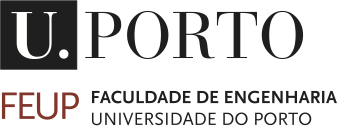   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p><b>Anibal C. Matos </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# "Visual Inspection of Offshore Structures"

Unmanned Aerial Vehicles (UAVs) have revolutionized data collection for inspection and mapping, particularly in challenging environments. UAVs are capable of gathering high-resolution imagery, thermal data and LiDAR point clouds, making them valuable assets for surveying and monitoring offshore structures like oil platforms, CALM buoys, wind turbines, and coastal infrastructure.

For this assignment, you will work with a multi-modal dataset collected by a UAV as it inspects a CALM buoy - an offshore structure essential for mooring tankers and transferring oil in open waters. The dataset includes visual, thermal, and LiDAR data, all pre-calibrated and ready to use, offering an authentic setup that reflects real-world challenges faced in offshore inspection.

**Objectives**

To create a dense and accurately textured 3D representation of the CALM buoy, merging thermal and spatial data into a unified model that closely resembles the actual structure. Thermal imaging is essential for inspecting CALM buoys because it enables the detection of temperature anomalies that can indicate structural issues, such as corrosion, leaks or mechanical wear, which might not be visible through standard visual inspections.

1. Data Integration: You will work with a combination of thermal images, and LiDAR point clouds, requiring you to integrate these diverse data types into a cohesive pipeline.

2. Point Cloud Texturization: enhance the point cloud by applying textures derived from the UAV's captured imagery, by aligning 2D images onto the 3D structure without needing to implement blending techniques (keeping the emphasis on alignment within the scope of the course). This will give your 3D model a more realistic appearance. By representing the temperature in the point cloud data, thermal imaging can help identify potential hotspots or areas of heat loss that signify material degradation or damage.

3. Point Cloud Registration: register multiple point clouds from different UAV viewpoints. This involves aligning and merging individual point clouds into a cohesive model, overcoming the spatial variations inherent in data collected from different perspectives.


## Description of the dataset

This assignment use data collected by an Unmanned Aerial Vehicle (UAV) during the inspection routines of a offshore structure in the [ATLANTIS Test Centre](https://www.linkedin.com/company/68810369/). The data retrieved by the UAV includes:

* **Thermographic information**: obtained by a FLIR Boson Radiometric 640x512 resolution camera, with lens distortion model $D_t$ and intrinsic matrix ($K_t$).

* **LiDAR**: is the ouster [OS1-64](https://ouster.com/products/hardware/os1-lidar-sensor) which has 64 channels with a maximum range of 200 metres, a vertical FOV of 45° (± 22.5°) and a precision of ± 0.5 to 3 cm.

* **Visual information**: obtained by a 640x480 resolution camera, with the lens distortion model $D_v$ and intrinsic matrix ($K_v$).

> `Dv: [-0.21292081375160646, 0.1767752984756973, 0.00016650108739115778, -7.265397248140523e-05, -0.05302482500821179]`

> `Kv: [767.942728, 0.0, 339.436073232339, 0.0, 767.068789, 231.644928, 0.0, 0.0, 1.0]`

> `Dt: [-0.504042, 0.26894, 0.003454, -0.000748, 0.0]`

>`Kt: [791.177953960177, 0.0, 317.436073232339, 0.0, 791.2141134510654, 260.3051663940424, 0.0, 0.0, 1.0]`


The extrinsic calibration parameters of this sensor setup is the following:

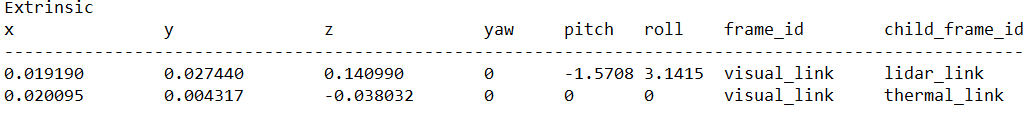

The visual, thermal and point clouds data is timestamped to be possible to select the visual, LiDAR and thermal data with closer timming. This timestamp is encoded directly in the filename of each JPEG or PCD file from the dataset.

* Visual images are named as “image_1693472857**485**557608”
* Point cloud (pcd files) are named as “pointcloud_1693472857**508**994”
* Thermal images are named as “image_1693472857**498**990366




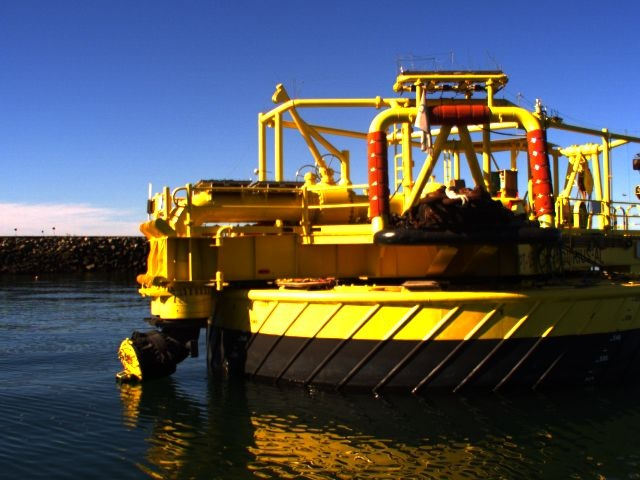

Figure 1 - Visual Images collected by UAV.

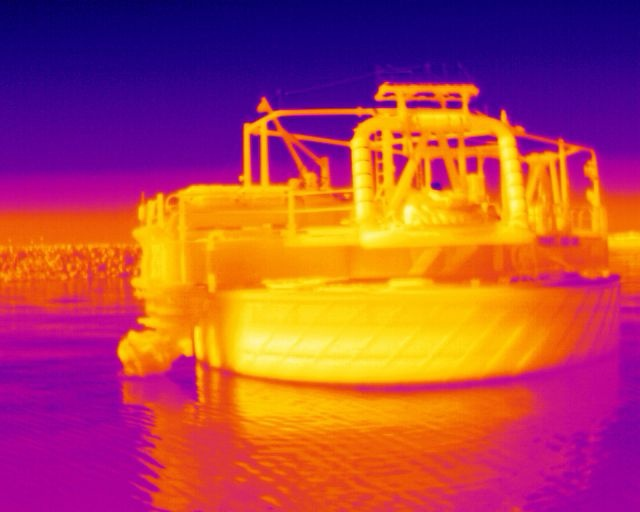

Figure 2 - Thermographic Images collected by UAV.

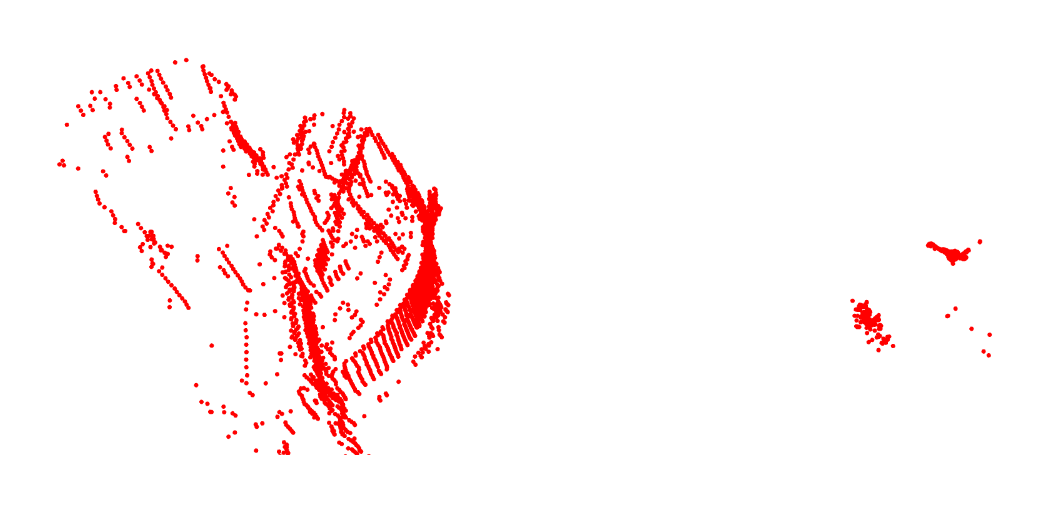

Figure 3 - Point cloud collected by UAV.

## Prepare Libraries and Download dataset

In [ ]:
# Install Open3D library
!pip install open3d

In [ ]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d

In [ ]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

In [ ]:
!wget 'https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EU91jtOCygFFgkkekfz2MMUBEbT7RCV-VNYsfDG0Kqm7Lg?download=1' -O DURIUS_d1.zip

In [ ]:
# Extract point clouds from ZIP file.
import zipfile
import os

with zipfile.ZipFile("DURIUS_d1.zip", mode="r") as archive:
  for file in archive.namelist():
    archive.extract(file, "dataset_uav/")

# Exercise 0 - Study and analysis of the sensor setup
Examine the perception system used by this UAV, which includes visual, thermal and LiDAR sensors. You can consult the datasheets of such sensors to support your technical discussion.







## 0.1 - Are there any challenge associated with this perception system?
>**Tip**: discuss the data integration, range, resolution, calibration and environmental factors, among others.

>**Tip**: max 7 sentences.

>**Tip**: provide all sources/references used.





<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

## 0.2 - Describe the process of calibrating different sensors to achieve accurate registration of the data from each sensor in a common coordinate system. Estimate the uncertainty induced by a 10cm range error in the lidar-to-thermal alignment procedure.

>**Tip**: Consider the minimum range of the LiDAR as 0.5m.

>**Tip**: max 5 sentences.

>**Tip**: provide all sources/references used.



<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>


# Exercise 1 - Point Cloud Texturization
Point clouds provide a powerful representation of 3D environments, capturing the spatial structure of objects and scenes with precision. However, raw point clouds lack visual realism as they consist of untextured geometric points. The challenge in this problem is to develop a point cloud texturization process that enhances the visual quality of point cloud data by mapping 2D textures onto 3D surfaces.

>**Problem Overview:**

>Design a function that receives the point cloud and the image, and uses the extrinsic and intrinsic calibration data to obtain the texture information that will be used to colorize the point cloud acquired by the LiDAR.

> **Expected output:** a point cloud with RGB colors in each point. This RGB color must be obtained using the thermal data.






> **From now on, this project is focused only on Thermal and LiDAR data.**

## Loading Images and Point Clouds

Start by selecting a point cloud and a image with similar timestamps.

In [ ]:
DIR_PCL = "dataset_uav/data_1/PCD/"
DIR_RGB = "dataset_uav/data_1/RGB/"
DIR_THE = "dataset_uav/data_1/Thermal/"

In [ ]:
"""
 this example: data is loaded individually. For loading many files --> glob library
"""

import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread(DIR_RGB+"image_1693472857485557608.jpg")
cv2_imshow(image)


image_t = cv2.imread(DIR_THE+"image_1693472857498990366.jpg")
cv2_imshow(image_t)


# Load a PCD file as a point cloud
pt_example = o3d.io.read_point_cloud(DIR_PCL+"pointcloud_1693472857608952.pcd", format='pcd')
if pt_example.is_empty():
  exit()


In [ ]:
o3d.visualization.draw_geometries([pt_example])

### 1.1 Pre-processing the point cloud
Apply some pre-processing techniques to improve the quality of the 3D Data.


In [ ]:
## To DO
## To DO
## To DO
## To DO

### 1.2 Define the Intrinsic and Extrinsic matrices, and transform the data for different coordinates

Use the Open3D objects/methods to modify the coordinate system of the point cloud.

In [ ]:
## To DO
## To DO
## To DO
## To DO

# Show the transformation matrix

### 1.3 Convert 3D Points to Image Plane, and show each 2D point in the RGB image

In [ ]:
## To DO
## To DO
## To DO
## To DO

In [ ]:
#Showing results (do not change)
image_show = image_t.copy()
image_projection_color = image_show*0.3 + range_map_color*0.9
cv2_imshow(image_projection_color)

### 1.4 Colorize the Point cloud of the DURIUS taking into consideration the RGB data from the Image

In [ ]:
## To DO
## To DO
## To DO
## To DO

In [ ]:
#Showing results (do not change)
pt_image_projection.colors = o3d.utility.Vector3dVector(RBG_pt)
o3d.visualization.draw_geometries([pt_image_projection])

### 1.5 Save the final point cloud with texture

In [ ]:
## To DO
## To DO
## To DO
## To DO

True

-

-

-

-

-

-

-

-

-----------------------------

# Exercise 2 - Developing a 3D Registration Pipeline

The objective of this task is to design and implement a sophisticated colorized registration pipeline capable of aligning multiple point clouds, each containing corresponding color data, into a unified, high-fidelity 3D model. This system should not only achieve precise geometric alignment but also maintain color consistency across the merged point clouds, resulting in a realistic and information-rich 3D representation.


>**Problem Overview:**

> Develop a robust colorized point cloud registration system that can process multiple input point clouds, each with RGB color information enconding the temperature captured by the thermal camera, and integrate them into a single, coherent 3D model. The system must ensure both high geometric accuracy and color continuity, thereby enhancing the overall visual fidelity and informativeness of the reconstructed model.

> **Expected output:** the unified, colorized point cloud representing the DURIUS infrastructure, where each point is associated with accurate thermal values.

* **50% of penalization:** if *> 75% of all point clouds available* in the dataset are used to create the unified point cloud.

* **25% of penalization:** if *> 25% of all point clouds available* in the dataset are used to create the unified point cloud.

* **0% of penalization:** for implemementations that produce an unified point cloud using *only 10 point clouds retrieved uniformly from all dataset*.





## 2.1 Prepare the dataset that will be used for the registration

a) Select the raw point clouds and corresponding images required for the registration process.

b) Load and apply colorization to each point cloud using the function developed in Part 1 of this assignment.

c) Save each colorized point cloud, ensuring texture information is preserved. Clearly indicate the total number of processed point clouds.

In [ ]:
# Load a PCD files with texture
## To DO
## To DO
## To DO
## To DO

#pt_s = [pt_1, pt_2, pt_3, pt_4....]

**Number of point clouds used:**

<font color='red'> !!! Complete here!!! </font>


## 2.2 Estimate a transformation matrix for each point cloud

In [ ]:
transformations = []

for icloud in range(len(pt_s)-1):
  ## To DO
  ## To DO
  ## To DO
  ## To DO

  #Print Stats
  print('initial guess:::', evaluation_start)
  print('after ICP :::', evaluation_end)
  print("Transformation is:", reg_p2p.transformation)


## 2.3 Concatenate the points of all point clouds and create the  unified point cloud.

In [ ]:
## To DO
## To DO
## To DO
## To DO

In [ ]:
#Showing results (do not change)
o3d.visualization.draw_geometries([pt_registered])

## 2.4 Post-processing the registered point cloud

In [ ]:
## To DO
## To DO
## To DO
## To DO

In [ ]:
#Showing results (do not change)
o3d.visualization.draw_geometries([pt_cloud_registered_filtered])
print(pt_cloud_registered_filtered)

## 2.5 Save the unified point cloud of DURIUS

In [ ]:
## To DO
## To DO
## To DO
## To DO

True

## 2.6 Comment the results obtained and identify potential improvements

>**Tip**: max 5 sentences.

>**Tip**: provide all sources/references used.

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

<font color='red'> !!! Complete here!!! </font>

-----------------
-----------------
-----------------


It's DONE!

**Instructions for submitting this work:**
* This colab file must be executed before the delivery.

* The code must be ready to run without permissions for accessing shared folders.

* To avoid problems with the Plotly, please encode an image in this colab (from printscreen) for each core result that you have.

* Deliver also in the Moodle the unified point cloud.
--------------------------

<font color='red'>
Disclaimer for the use of AI tools: complete the text that is placed in between brackets. Convert this disclaimer to PDF, sign it and deliver the PDF in Moodle.
</font>

I, [Student Name], declare that the work presented in this assignment titled "[Assignment Title]" was completed independently, except where explicitly noted. I confirm the following with regard to the use of AI tools:

**Extent of AI Tool Contribution:**

I have used the following AI tool(s) for assistance in this assignment:

1. Tool(s) Used: [List AI tools used, e.g., ChatGPT, Grammarly, QuillBot, etc.]
Nature of Assistance: [Specify the task(s) for which the AI tool was used, e.g., brainstorming ideas, refining language, generating summaries, grammar correction, etc.]
2. Percentage of AI Contribution: [Estimate the percentage of the assignment influenced by the AI tool.]
3. Human Oversight and Contribution:
Despite the use of AI tools, I confirm that the critical thinking, analysis, problem-solving, and final decision-making processes in this assignment were carried out by me. The AI tools were used solely as support for the following purposes: [Elaborate on how the AI tool helped, e.g., improving readability, offering suggestions for structure, or enhancing clarity.]


**Originality and Integrity:**
I take full responsibility for ensuring that the content of this assignment is original and properly cited where applicable. The use of AI tools did not result in any unintentional plagiarism or misrepresentation of ideas from external sources.

**Compliance with Academic Integrity Guidelines:**
I understand the importance of academic integrity, and I confirm that the usage of AI tools complies with the guidelines provided by [School/University Name]. All AI-generated outputs were critically evaluated and appropriately incorporated into the final submission.

Signed,
[Student Name]
[Date]